In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as _pd
from sklearn import preprocessing
import numpy as _np
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))


import warnings; 
warnings.simplefilter('ignore')


In [2]:
hh = _pd.read_csv("./data/hhtype.csv")
per = _pd.read_csv("./data/pertype.csv")
access = _pd.read_csv("./data/accessibility.csv")

In [3]:
hh["incom"] = _np.where(hh["incom"]>5, 6, hh["incom"])
num_adults = per.groupby("sampn",as_index=False).apply(lambda x: x[x['age'] >=18]["perno"].count())

In [4]:
hh["num_adults"] = num_adults

In [5]:
hh = _pd.merge(hh, access[["TAZ_NUM","ACCESS4","ACCESS5","ACCESS6"]], left_on="hhtaz", right_on="TAZ_NUM", how="left")

In [6]:
hh["auto_access"] = _np.log(1+hh["ACCESS4"])
hh["tran_access"] = _np.log(1+hh["ACCESS5"])
hh["non_mot_access"] = _np.log(1+hh["ACCESS6"])

In [7]:
hh["hhveh"] = _np.where(hh["hhveh"]>=3, 3, hh["hhveh"])
hh.fillna(0, inplace=True)

In [9]:
features = ["sectr", "incom", "num_adults", "tran_access", "auto_access", "non_mot_access", "numWorkers"]
# number of workers, auto dependency for workers

In [10]:
y = hh["hhveh"]
x = hh[features]
x_val_more = x.copy()
x_val_less = x.copy()
x_val_more["tran_access"] = x_val_more["tran_access"] + 0.6
x_val_less["tran_access"] = x_val_less["tran_access"] - 0.6

In [13]:
## Random forest

In [14]:
clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)

In [15]:
clf.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
print(clf.feature_importances_)
pred_more_rf = clf.predict(x_val_more)
pred_less_rf = clf.predict(x_val_less)

[0.08616137 0.21702145 0.12108377 0.14379775 0.14875013 0.14194373
 0.1412418 ]


In [17]:
## SVM
clf_svm = svm.SVC(gamma=1, decision_function_shape='ovo')
clf_svm.fit(x,y)
pred_more_svm = clf_svm.predict(x_val_more)
pred_less_svm = clf_svm.predict(x_val_less)

In [18]:
# NN
clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 4),activation="logistic", random_state=1)
clf_nn.fit(x,y)
pred_more_nn = clf_nn.predict(x_val_more)
pred_less_nn = clf_nn.predict(x_val_less)

In [19]:
# KNN
clf_knn = KNeighborsClassifier(n_neighbors=9)
clf_knn.fit(x,y)
pred_more_knn = clf_knn.predict(x_val_more) 
pred_less_knn = clf_knn.predict(x_val_less) 

In [29]:
mnl_prob_more = _pd.read_csv("mnl_prob_all_more_access.csv")
mnl_prob_less = _pd.read_csv("mnl_prob_all_less_access.csv")

In [30]:
mnl_prob_more.rename(columns={"X11":"prob0", "X2":"prob1","X3":"prob2","X4":"prob3"}, inplace=True)
mnl_prob_less.rename(columns={"X11":"prob0", "X2":"prob1","X3":"prob2","X4":"prob3"}, inplace=True)

In [31]:
hh_pred_more = _pd.merge(hh, mnl_prob_more[["sampn","prob0","prob1","prob2","prob3"]], how="left", on="sampn")
hh_pred_less = _pd.merge(hh, mnl_prob_less[["sampn","prob0","prob1","prob2","prob3"]], how="left", on="sampn")

In [32]:
hh_pred_more["pred_rf"] = pred_more_rf
hh_pred_more["pred_svm"] = pred_more_svm
hh_pred_more["pred_knn"] = pred_more_knn
hh_pred_more["pred_nn"] = pred_more_nn

hh_pred_less["pred_rf"] = pred_less_rf
hh_pred_less["pred_svm"] = pred_less_svm
hh_pred_less["pred_knn"] = pred_less_knn
hh_pred_less["pred_nn"] = pred_less_nn



In [33]:
def pick_highest_prob(data):
    data["highest_prob"] = data[['prob0','prob1','prob2',"prob3"]].max(axis=1)
    data["pred_mnl_highest"] = _np.where(data["highest_prob"]==data["prob0"], 0,
                                  _np.where(data["highest_prob"]==data["prob1"], 1, 
                                           _np.where(data["highest_prob"]==data["prob2"], 2, 3)))
    
    return data["pred_mnl_highest"]


In [34]:
def microsimulate_choice(data):
    data["cdf_prob0"] = data["prob0"]
    data["cdf_prob1"] = data["cdf_prob0"] + data["prob1"]
    data["cdf_prob2"] = data["cdf_prob1"] + data["prob2"]
    data["cdf_prob3"] = data["cdf_prob2"] + data["prob3"]

    random.seed(11111)
    data['rand'] = [random.random() for k in data.index]

    data["pred_mnl_micro"] = _np.where(data["rand"] <= data["cdf_prob0"], 0,
                                      _np.where(data["rand"] <= data["cdf_prob1"], 1, 
                                               _np.where(data["rand"] <= data["cdf_prob2"], 2, 3)))
    
    return data["pred_mnl_micro"]

In [35]:
def get_prediction_comparison_data(data):
    data["pred_type_rf"] = _np.where(data["pred_rf"] > data["hhveh"], "Over", _np.where(data["pred_rf"] == data["hhveh"], "Match", "Under"))
    data["pred_type_svm"] = _np.where(data["pred_svm"] > data["hhveh"], "Over", _np.where(data["pred_svm"] == data["hhveh"], "Match", "Under"))
    data["pred_type_nn"] = _np.where(data["pred_nn"] > data["hhveh"], "Over", _np.where(data["pred_nn"] == data["hhveh"], "Match", "Under"))
    data["pred_type_knn"] = _np.where(data["pred_knn"] > data["hhveh"], "Over", _np.where(data["pred_knn"] == data["hhveh"], "Match", "Under"))
    data["pred_type_mnl_highest"] = _np.where(data["pred_mnl_highest"] > data["hhveh"], "Over", _np.where(data["pred_mnl_highest"] == data["hhveh"], "Match", "Under"))
    data["pred_type_mnl_micro"] = _np.where(data["pred_mnl_micro"] > data["hhveh"], "Over", _np.where(data["pred_mnl_micro"] == data["hhveh"], "Match", "Under"))
    
    pred_count_rf = data.groupby("pred_type_rf", as_index=False)["pred_rf"].count()
    pred_count_rf["pred_rf"] = pred_count_rf["pred_rf"]*100/pred_count_rf["pred_rf"].sum()
    
    pred_count_svm = data.groupby("pred_type_svm", as_index=False)["pred_svm"].count()
    pred_count_svm["pred_svm"] = pred_count_svm["pred_svm"]*100/pred_count_svm["pred_svm"].sum()
    
    pred_count_nn = data.groupby("pred_type_nn", as_index=False)["pred_nn"].count()
    pred_count_nn["pred_nn"] = pred_count_nn["pred_nn"]*100/pred_count_nn["pred_nn"].sum()
    
    pred_count_knn = data.groupby("pred_type_knn", as_index=False)["pred_knn"].count()
    pred_count_knn["pred_knn"] = pred_count_knn["pred_knn"]*100/pred_count_knn["pred_knn"].sum()
    
    pred_count_mnl_highest = data.groupby("pred_type_mnl_highest", as_index=False)["pred_mnl_highest"].count()
    pred_count_mnl_highest["pred_mnl_highest"] = pred_count_mnl_highest["pred_mnl_highest"]*100/pred_count_mnl_highest["pred_mnl_highest"].sum()
    
    pred_count_mnl_micro = data.groupby("pred_type_mnl_micro", as_index=False)["pred_mnl_micro"].count()
    pred_count_mnl_micro["pred_mnl_micro"] = pred_count_mnl_micro["pred_mnl_micro"]*100/pred_count_mnl_micro["pred_mnl_micro"].sum()
    
    return _pd.concat([pred_count_rf, pred_count_svm, pred_count_nn, pred_count_knn, pred_count_mnl_highest, pred_count_mnl_micro], axis=1)
    

In [36]:
def get_prediction_type_plot(data, figname, title="Prediction by different statistical methods"):
    fig, ax = plt.subplots()
    index = _np.arange(3)
    bar_width = 0.1
    opacity = 0.8

    fig1 = plt.bar(index, data["pred_rf"], bar_width,
    alpha=opacity,
    label='Random Forest')

    fig2 = plt.bar(index + bar_width,  data["pred_svm"], bar_width,
    alpha=opacity,
    label='SVM')

    fig3 = plt.bar(index + 2*bar_width,  data["pred_nn"], bar_width,
    alpha=opacity,
    label='Neural Network')

    fig4 = plt.bar(index + 3*bar_width,  data["pred_knn"], bar_width,
    alpha=opacity,
    label='K nearest neighbor')

    fig5 = plt.bar(index + 4*bar_width,  data["pred_mnl_highest"], bar_width,
    alpha=opacity,
    label='MNL - highest prob chosen')

    fig6 = plt.bar(index + 5*bar_width,  data["pred_mnl_micro"], bar_width,
    alpha=opacity,
    label='MNL - Microsimulate')

    plt.xlabel('Prediction type')
    plt.ylabel('Percentage of households')
    plt.title(title)
    plt.xticks(index + bar_width, ('Match', 'Over', 'Under'))
    plt.legend()
    ax.yaxis.set_major_formatter(formatter)

    ax.set_ylim(0, 90)
    plt.savefig(figname+".png", quality=95 )
    
    return plt.show()

In [37]:
def get_agg_auto_ownership_share(data):
    
   
    obs_agg_rf = data.groupby("hhveh", as_index=False)["sampn"].count()
    obs_agg_rf["sampn"] =  obs_agg_rf["sampn"]*100/obs_agg_rf["sampn"].sum()
    obs_agg_rf.rename(columns={"sampn":"observed"}, inplace=True)
    
    pred_agg_rf = data.groupby("pred_rf", as_index=False)["sampn"].count()
    pred_agg_rf["sampn"] =  pred_agg_rf["sampn"]*100/pred_agg_rf["sampn"].sum()    
    pred_agg_rf.rename(columns={"sampn":"rf"}, inplace=True)
    
    pred_agg_svm = data.groupby("pred_svm", as_index=False)["sampn"].count()
    pred_agg_svm["sampn"] =  pred_agg_svm["sampn"]*100/pred_agg_svm["sampn"].sum()
    pred_agg_svm.rename(columns={"sampn":"svm"}, inplace=True)
    
    pred_agg_nn = data.groupby("pred_nn", as_index=False)["sampn"].count()
    pred_agg_nn["sampn"] =  pred_agg_nn["sampn"]*100/pred_agg_nn["sampn"].sum()
    pred_agg_nn.rename(columns={"sampn":"nn"}, inplace=True)
        
    pred_agg_knn = data.groupby("pred_knn", as_index=False)["sampn"].count()
    pred_agg_knn["sampn"] =  pred_agg_knn["sampn"]*100/pred_agg_knn["sampn"].sum()
    pred_agg_knn.rename(columns={"sampn":"knn"}, inplace=True)
    
    pred_agg_mnl_highest = data.groupby("pred_mnl_highest", as_index=False)["sampn"].count()
    pred_agg_mnl_highest["sampn"] =  pred_agg_mnl_highest["sampn"]*100/pred_agg_mnl_highest["sampn"].sum()
    pred_agg_mnl_highest.rename(columns={"sampn":"highest"}, inplace=True)
    
    pred_agg_mnl_micro = data.groupby("pred_mnl_micro", as_index=False)["sampn"].count()
    pred_agg_mnl_micro["sampn"] =  pred_agg_mnl_micro["sampn"]*100/pred_agg_mnl_micro["sampn"].sum()
    pred_agg_mnl_micro.rename(columns={"sampn":"micro"}, inplace=True)
    #add_row(pred_agg_svm, [3,0])
    return _pd.concat([obs_agg_rf, pred_agg_rf, pred_agg_svm, pred_agg_nn, pred_agg_knn, pred_agg_mnl_highest, pred_agg_mnl_micro], axis=1)

In [38]:
def get_agg_auto_ownership_plot(data, figname, title='Aggrregate shares by different statistical methods'):
        # create plot
    fig, ax = plt.subplots()
    index = _np.arange(4)
    bar_width = 0.1
    opacity = 0.8

    fig0 = plt.bar(index, data["observed"], bar_width,
    alpha=opacity,
    label='Observed')



    fig1 = plt.bar(index + bar_width, data["rf"], bar_width,
    alpha=opacity,
    label='Random Forest')

    fig2 = plt.bar(index + 2*bar_width,  data["svm"], bar_width,
    alpha=opacity,
    label='SVM')

    fig3 = plt.bar(index + 3*bar_width,  data["nn"], bar_width,
    alpha=opacity,
    label='Neural Network')

    fig4 = plt.bar(index + 4*bar_width,  data["knn"], bar_width,
    alpha=opacity,
    label='K nearest neighbor')

    fig5 = plt.bar(index + 5*bar_width,  data["highest"], bar_width,
    alpha=opacity,
    label='MNL - highest prob chosen')

    fig6 = plt.bar(index + 6*bar_width,  data["micro"], bar_width,
    alpha=opacity,
    label='MNL - Microsimulate')

    plt.xlabel('Car ownership level')
    plt.ylabel('Percentage of households')
    plt.title(title)
    plt.xticks(index + bar_width, ('0 car', '1 car', '2 cars', "3+ cars"))
    plt.legend()
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylim(0, 80)
    plt.savefig(figname+".png", quality=95 )
    return plt.show()

In [39]:
hh_pred_more["pred_mnl_highest"] = pick_highest_prob(hh_pred_more)
hh_pred_more["pred_mnl_micro"] = microsimulate_choice(hh_pred_more)

hh_pred_less["pred_mnl_highest"] = pick_highest_prob(hh_pred_less)
hh_pred_less["pred_mnl_micro"] = microsimulate_choice(hh_pred_less)


In [41]:
auto_share_more = get_agg_auto_ownership_share(hh_pred_more)
auto_share_more.fillna(0, inplace=True)

auto_share_less = get_agg_auto_ownership_share(hh_pred_less)
auto_share_less.fillna(0, inplace=True)



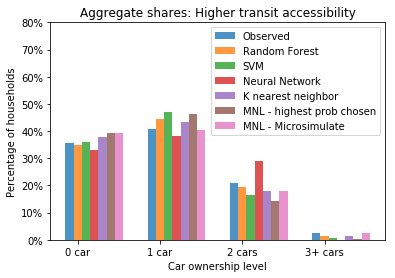

In [42]:
get_agg_auto_ownership_plot(auto_share_more, "aggshare_more_acc", "Aggregate shares: Higher transit accessibility")

In [43]:
auto_share_more.to_csv("more_access.csv")
auto_share_less.to_csv("less_access.csv")

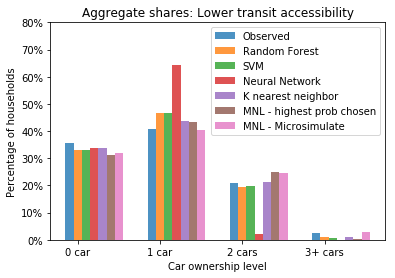

In [44]:
get_agg_auto_ownership_plot(auto_share_less, "aggshare_more_acc", "Aggregate shares: Lower transit accessibility")

In [45]:
mnl_random = _pd.read_csv("mnl_prob_random.csv")
mnl_random.rename(columns={"X11":"prob0", "X2":"prob1","X3":"prob2","X4":"prob3"}, inplace=True)

In [46]:
hh_random = _pd.merge(hh, mnl_random[["sampn","weights_random","prob0","prob1","prob2","prob3"]], how="left", on="sampn")

In [47]:
y_train_random = hh_random[hh_random["weights_random"]==1]["hhveh"]
x_train_random = hh_random[hh_random["weights_random"]==1][features]

y_val_random = hh_random[hh_random["weights_random"]==0]["hhveh"]
x_val_random = hh_random[hh_random["weights_random"]==0][features]



In [48]:
clf_rand = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
clf_rand.fit(x_train_random, y_train_random)
pred_rand_rf = clf_rand.predict(x_val_random)
pred_rand_train_rf = clf_rand.predict(x_train_random)

In [49]:
## SVM
clf_rand_svm = svm.SVC(gamma=1, decision_function_shape='ovo')
clf_rand_svm.fit(x_train_random,y_train_random)
pred_rand_svm = clf_rand_svm.predict(x_val_random)
pred_rand_train_svm = clf_rand_svm.predict(x_train_random)

In [50]:
## NN
clf_rand_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 4),activation="logistic", random_state=1)
clf_rand_nn.fit(x_train_random,y_train_random)
pred_rand_nn = clf_rand_nn.predict(x_val_random)
pred_rand_train_nn = clf_rand_nn.predict(x_train_random)

In [51]:
# KNN
clf_rand_knn = KNeighborsClassifier(n_neighbors=9)
clf_rand_knn.fit(x_train_random,y_train_random)
pred_rand_knn = clf_rand_knn.predict(x_val_random) 
pred_rand_train_knn = clf_rand_knn.predict(x_train_random) 

In [52]:
hh_rand_pred = hh_random[hh_random["weights_random"]==0]

hh_rand_pred["pred_rf"] = pred_rand_rf
hh_rand_pred["pred_svm"] = pred_rand_svm
hh_rand_pred["pred_knn"] = pred_rand_knn
hh_rand_pred["pred_nn"] = pred_rand_nn

In [53]:
hh_rand_train_pred = hh_random[hh_random["weights_random"]==1]

hh_rand_train_pred["pred_rf"] = pred_rand_train_rf
hh_rand_train_pred["pred_svm"] = pred_rand_train_svm
hh_rand_train_pred["pred_knn"] = pred_rand_train_knn
hh_rand_train_pred["pred_nn"] = pred_rand_train_nn

In [54]:
hh_rand_pred["pred_mnl_highest"] = pick_highest_prob(hh_rand_pred)
hh_rand_pred["pred_mnl_micro"] = microsimulate_choice(hh_rand_pred)
hh_rand_train_pred["pred_mnl_highest"] = pick_highest_prob(hh_rand_train_pred)
hh_rand_train_pred["pred_mnl_micro"] = microsimulate_choice(hh_rand_train_pred)


In [55]:
import warnings; warnings.simplefilter('ignore')

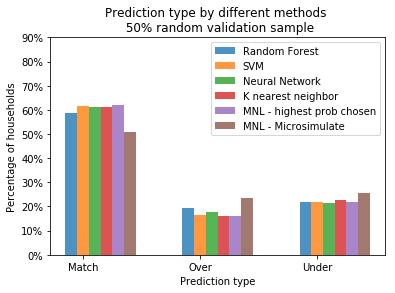

In [56]:
pred_rand = get_prediction_comparison_data(hh_rand_pred)
get_prediction_type_plot(pred_rand, "hitrate_50_sample_random_val",title="Prediction type by different methods \n 50% random validation sample")

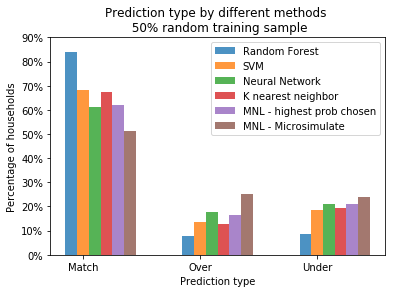

In [57]:
pred_rand_train = get_prediction_comparison_data(hh_rand_train_pred)
get_prediction_type_plot(pred_rand_train, "hitrate_50_sample_random_train", title="Prediction type by different methods \n 50% random training sample")

In [58]:
hh_rand_train_pred["pred_mnl_highest"] = pick_highest_prob(hh_rand_train_pred)
hh_rand_train_pred["pred_mnl_micro"] = microsimulate_choice(hh_rand_train_pred)

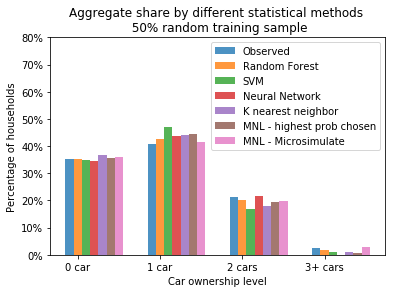

In [59]:

auto_share_rand = get_agg_auto_ownership_share(hh_rand_pred)
auto_share_rand.fillna(0, inplace=True)
get_agg_auto_ownership_plot(auto_share_rand,"aggshare_50_sample_random_train", title="Aggregate share by different statistical methods \n 50% random training sample")

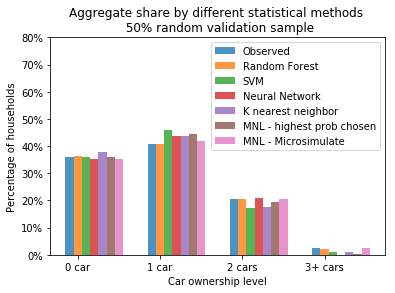

In [60]:

auto_share_train_rand = get_agg_auto_ownership_share(hh_rand_train_pred)
auto_share_train_rand.fillna(0, inplace=True)
get_agg_auto_ownership_plot(auto_share_train_rand,"aggshare_50_sample_random_validation" ,title="Aggregate share by different statistical methods \n 50% random validation sample")

In [61]:
# bias sample

In [62]:
mnl_bias = _pd.read_csv("mnl_prob_bias_hhveh.csv")
mnl_bias.rename(columns={"X11":"prob0", "X2":"prob1","X3":"prob2","X4":"prob3"}, inplace=True)

In [63]:
hh_bias = _pd.merge(hh, mnl_bias[["sampn","weights_bias","prob0","prob1","prob2","prob3"]], how="left", on="sampn")

In [64]:
train_data = hh_bias[hh_bias["weights_bias"] == 1]

In [65]:
y_train_bias = hh_bias[hh_bias["weights_bias"]==1]["hhveh"]
x_train_bias = hh_bias[hh_bias["weights_bias"]==1][features]

y_val_bias = hh_bias[hh_bias["weights_bias"]==0]["hhveh"]
x_val_bias = hh_bias[hh_bias["weights_bias"]==0][features]



In [66]:
clf_bias = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
clf_bias.fit(x_train_bias, y_train_bias)
pred_bias_rf = clf_bias.predict(x_val_bias)
pred_bias_train_rf = clf_bias.predict(x_train_bias)

In [67]:
## SVM
clf_bias_svm = svm.SVC(gamma=1, decision_function_shape='ovo')
clf_bias_svm.fit(x_train_bias,y_train_bias)
pred_bias_svm = clf_bias_svm.predict(x_val_bias)
pred_bias_train_svm = clf_bias_svm.predict(x_train_bias)

In [68]:
_np.array(_np.unique(pred_bias_svm, return_counts=True)).T

array([[   0, 1758],
       [   1, 2562],
       [   2,  820],
       [   3,   14]], dtype=int64)

In [69]:
_np.array(_np.unique(y_train_bias, return_counts=True)).T

array([[   0, 2605],
       [   1, 2016],
       [   2,  666],
       [   3,   39]], dtype=int64)

In [70]:
## NN
clf_bias_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 4),activation="logistic", random_state=1)
clf_bias_nn.fit(x_train_bias,y_train_bias)
pred_bias_nn = clf_bias_nn.predict(x_val_bias)
pred_bias_train_nn = clf_bias_nn.predict(x_train_bias)

In [71]:

# KNN
clf_bias_knn = KNeighborsClassifier(n_neighbors=9)
clf_bias_knn.fit(x_train_bias,y_train_bias)
pred_bias_knn = clf_bias_knn.predict(x_val_bias) 
pred_bias_train_knn = clf_bias_knn.predict(x_train_bias) 


In [72]:
hh_bias_pred = hh_bias[hh_bias["weights_bias"]==0]
hh_bias_train_pred = hh_bias[hh_bias["weights_bias"]==1]

In [73]:
hh_bias_pred["pred_rf"] = pred_bias_rf
hh_bias_pred["pred_svm"] = pred_bias_svm
hh_bias_pred["pred_knn"] = pred_bias_knn
hh_bias_pred["pred_nn"] = pred_bias_nn


In [74]:
hh_bias_pred["pred_rf"].value_counts().sort_index()

0    1726
1    2287
2    1104
3      37
Name: pred_rf, dtype: int64

In [75]:
hh_bias_pred["hhveh"].value_counts().sort_index()

0    1134
1    2269
2    1527
3     224
Name: hhveh, dtype: int64

In [76]:
hh_bias_train_pred["pred_rf"] = pred_bias_train_rf
hh_bias_train_pred["pred_svm"] = pred_bias_train_svm
hh_bias_train_pred["pred_knn"] = pred_bias_train_knn
hh_bias_train_pred["pred_nn"] = pred_bias_train_nn

In [77]:
hh_bias_pred["pred_mnl_highest"] = pick_highest_prob(hh_bias_pred)
hh_bias_pred["pred_mnl_micro"] = microsimulate_choice(hh_bias_pred)

In [78]:
hh_bias_train_pred["pred_mnl_highest"] = pick_highest_prob(hh_bias_train_pred)
hh_bias_train_pred["pred_mnl_micro"] = microsimulate_choice(hh_bias_train_pred)

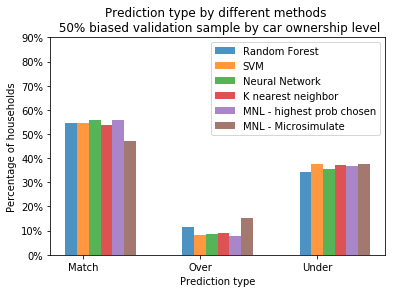

In [79]:
pred_bias = get_prediction_comparison_data(hh_bias_pred)
get_prediction_type_plot(pred_bias, "hitrate_50_sample_biased_hhveh_val", title="Prediction type by different methods \n 50% biased validation sample by car ownership level")


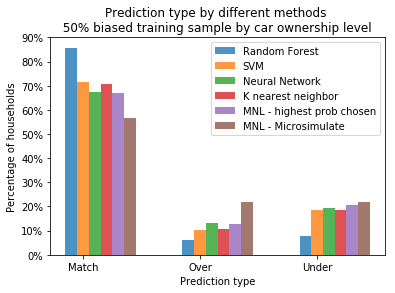

In [80]:
pred_bias_train = get_prediction_comparison_data(hh_bias_train_pred)
get_prediction_type_plot(pred_bias_train,"hitrate_50_sample_biased_hhveh_train", title="Prediction type by different methods \n 50% biased training sample by car ownership level ")

In [81]:
auto_share_bias = get_agg_auto_ownership_share(hh_bias_pred)

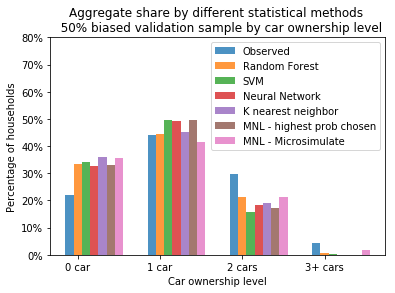

In [82]:

auto_share_bias.fillna(0, inplace=True)
get_agg_auto_ownership_plot(auto_share_bias,"aggshare_50_sample_biased_hhveh_val", title="Aggregate share by different statistical methods \n  50% biased validation sample by car ownership level")


In [83]:
auto_share_bias_train = get_agg_auto_ownership_share(hh_bias_train_pred)

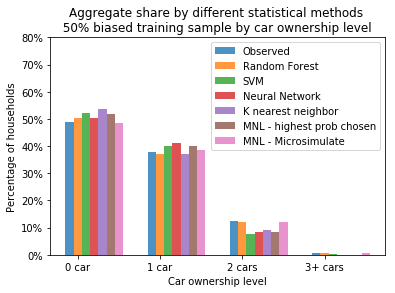

In [84]:

auto_share_bias_train.fillna(0, inplace=True)
get_agg_auto_ownership_plot(auto_share_bias_train, "aggshare_50_sample_biased_hhveh_train",title="Aggregate share by different statistical methods \n 50% biased training sample by car ownership level ")


In [85]:
# Bias by income level
mnl_bias_inc = _pd.read_csv("mnl_prob_bias_inc.csv")
mnl_bias_inc.rename(columns={"X11":"prob0", "X2":"prob1","X3":"prob2","X4":"prob3"}, inplace=True)

In [86]:
hh_bias_inc = _pd.merge(hh, mnl_bias[["sampn","weights_bias_inc","prob0","prob1","prob2","prob3"]], how="left", on="sampn")
train_data = hh_bias_inc[hh_bias_inc["weights_bias_inc"] == 1]

In [87]:
y_train_bias_inc = hh_bias_inc[hh_bias_inc["weights_bias_inc"]==1]["hhveh"]
x_train_bias_inc = hh_bias_inc[hh_bias_inc["weights_bias_inc"]==1][features]

y_val_bias_inc = hh_bias_inc[hh_bias_inc["weights_bias_inc"]==0]["hhveh"]
x_val_bias_inc = hh_bias_inc[hh_bias_inc["weights_bias_inc"]==0][features]

In [88]:
clf_bias_inc = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
clf_bias_inc.fit(x_train_bias_inc, y_train_bias_inc)
pred_bias_inc_rf = clf_bias_inc.predict(x_val_bias_inc)
pred_bias_inc_train_rf = clf_bias_inc.predict(x_train_bias_inc)


In [89]:

## SVM
clf_bias_inc_svm = svm.SVC(gamma=1, decision_function_shape='ovo')
clf_bias_inc_svm.fit(x_train_bias_inc,y_train_bias_inc)
pred_bias_inc_svm = clf_bias_inc_svm.predict(x_val_bias_inc)
pred_bias_inc_train_svm = clf_bias_inc_svm.predict(x_train_bias_inc)


In [90]:
## NN
clf_bias_inc_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(7, 4),activation="logistic", random_state=1)
clf_bias_inc_nn.fit(x_train_bias_inc,y_train_bias_inc)
pred_bias_inc_nn = clf_bias_inc_nn.predict(x_val_bias_inc)
pred_bias_inc_train_nn = clf_bias_inc_nn.predict(x_train_bias_inc)


In [91]:
# KNN
clf_bias_inc_knn = KNeighborsClassifier(n_neighbors=9)
clf_bias_inc_knn.fit(x_train_bias_inc,y_train_bias_inc)
pred_bias_inc_knn = clf_bias_inc_knn.predict(x_val_bias_inc) 
pred_bias_inc_train_knn = clf_bias_inc_knn.predict(x_train_bias_inc) 

In [92]:
hh_bias_inc_pred = hh_bias_inc[hh_bias_inc["weights_bias_inc"]==0]
hh_bias_inc_train_pred = hh_bias_inc[hh_bias_inc["weights_bias_inc"]==1]


In [93]:
hh_bias_inc_pred["pred_rf"] = pred_bias_inc_rf
hh_bias_inc_pred["pred_svm"] = pred_bias_inc_svm
hh_bias_inc_pred["pred_knn"] = pred_bias_inc_knn
hh_bias_inc_pred["pred_nn"] = pred_bias_inc_nn

In [94]:
hh_bias_inc_train_pred["pred_rf"] = pred_bias_inc_train_rf
hh_bias_inc_train_pred["pred_svm"] = pred_bias_inc_train_svm
hh_bias_inc_train_pred["pred_knn"] = pred_bias_inc_train_knn
hh_bias_inc_train_pred["pred_nn"] = pred_bias_inc_train_nn

In [95]:
hh_bias_inc_pred["pred_mnl_highest"] = pick_highest_prob(hh_bias_inc_pred)
hh_bias_inc_pred["pred_mnl_micro"] = microsimulate_choice(hh_bias_inc_pred)

In [96]:
hh_bias_inc_train_pred["pred_mnl_highest"] = pick_highest_prob(hh_bias_inc_train_pred)
hh_bias_inc_train_pred["pred_mnl_micro"] = microsimulate_choice(hh_bias_inc_train_pred)


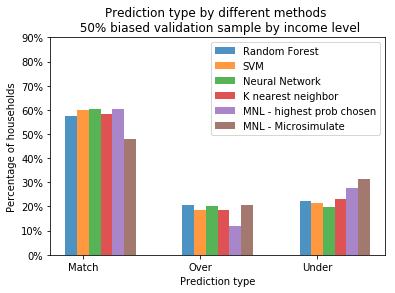

In [97]:
pred_bias_inc = get_prediction_comparison_data(hh_bias_inc_pred)
get_prediction_type_plot(pred_bias_inc, "hitrate_50_sample_biased_inc_val", title="Prediction type by different methods \n 50% biased validation sample by income level")



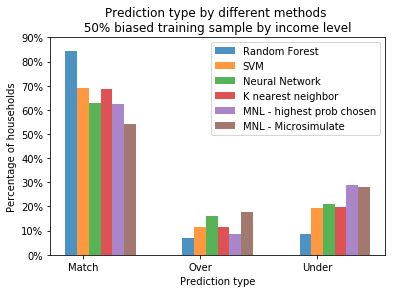

In [98]:
pred_bias_inc_train = get_prediction_comparison_data(hh_bias_inc_train_pred)
get_prediction_type_plot(pred_bias_inc_train,"hitrate_50_sample_biased_inc_train", title="Prediction type by different methods \n 50% biased training sample by income level ")


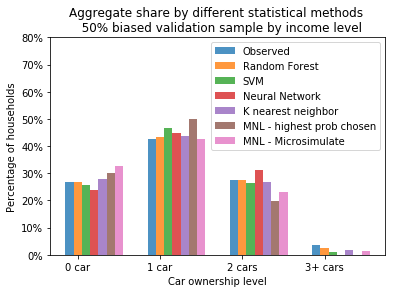

In [99]:
auto_share_bias_inc = get_agg_auto_ownership_share(hh_bias_inc_pred)
auto_share_bias_inc.fillna(0, inplace=True)
get_agg_auto_ownership_plot(auto_share_bias_inc,"aggshare_50_sample_biased_hhveh_val", title="Aggregate share by different statistical methods \n  50% biased validation sample by income level")


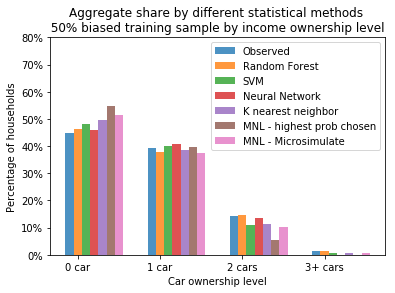

In [100]:
auto_share_bias_inc_train = get_agg_auto_ownership_share(hh_bias_inc_train_pred)
auto_share_bias_inc_train.fillna(0, inplace=True)
get_agg_auto_ownership_plot(auto_share_bias_inc_train, "aggshare_50_sample_biased_hhveh_train",title="Aggregate share by different statistical methods \n 50% biased training sample by income ownership level ")

